In [1]:
import os
import pandas as pd

pdb_sugar_files = os.listdir("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/pdb_debug2")
colvar_files = os.listdir("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/colvar")

sugar_files_df = pd.DataFrame({"sugar_file_names": pdb_sugar_files})
colvar_files_df = pd.DataFrame({"colvar_file_names": colvar_files})

In [2]:
#Tira os arquivos de backup

# Filtrar e excluir os valores que começam com "bck"
nobck_colvar_df = colvar_files_df[~colvar_files_df['colvar_file_names'].str.startswith('bck')]
#Exclui da lista
nobck_colvar_df = nobck_colvar_df[~nobck_colvar_df['colvar_file_names'].str.contains('6pd4_NAG_68238')]

In [3]:
# Filtrar nobck_colvar_df para manter somente os valores que são substrings dos valores de sugar_files_df
def is_substring_in_any(value, substrings):
    return any(value in substring for substring in substrings)

# Aplicar a função para filtrar as linhas
filtered_df = nobck_colvar_df[nobck_colvar_df['colvar_file_names'].apply(lambda x: is_substring_in_any(x, sugar_files_df['sugar_file_names']))]

In [4]:
#Calcula bfactor dos açúcares
from tqdm import tqdm
from SIC2023_resolution import *

# Função para processar o arquivo
def pdb_calc_bfactor(input_file):
    hetatm_lines = []
    
    # Ler o arquivo e filtrar as linhas que começam com "HETATM"
    with open(input_file, 'r') as file:
        for line in file:
            if line.startswith('HETATM'):
                # Remover espaços extras e separar por vírgula
                processed_line = ','.join(line.split())
                hetatm_lines.append(processed_line)
    
    # Converter a lista de linhas processadas em um DataFrame
    df = pd.DataFrame(hetatm_lines, columns=['line'])
    
    # Separar as colunas corretamente
    df = df['line'].str.split(',', expand=True)
    #print(df)
    try:
        # Nomear as colunas conforme a estrutura do arquivo PDB
        df.columns = ['record', 'atom_number', 'atom_name', 'residue_name', 'chain_id', 'residue_number',
                    'x', 'y', 'z', 'occupancy', 'temperature_factor', 'element']
        #bfactor_mean = df['B_iso_or_equiv'].mean() 
        #df.iloc[:, 10] = df.iloc[:, 10].astype(float)
        # Convertendo e atualizando a coluna
        df = df.assign(col_10=pd.to_numeric(df.iloc[:, 0], errors='coerce'))
        bfactor_mean = df.iloc[:, 10].mean() 
        with open("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/bfactors.txt", "a") as f:
            f.write(f"{input_file},{bfactor_mean}\n")
    except Exception as e:
        with open("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/logs/bfactors_log.txt", "a") as f:
            f.write("BFACTOR CALC Exception in " + input_file + ": " + str(e) + "\n")

# Função para processar o arquivo e calcular a média do B-factor
def calculate_bfactor_average(input_file):
    hetatm_lines = []
    
    # Ler o arquivo e filtrar as linhas que começam com "HETATM"
    with open(input_file, 'r') as file:
        for line in file:
            if line.startswith('HETATM'):
                hetatm_lines.append(line)
    
    # Processar as linhas HETATM
    data = []
    for line in hetatm_lines:
        # Extrair o B-factor (coluna 11, índices 60-65)
        bfactor = float(line[60:66].strip())
        data.append(bfactor)
    
    # Calcular a média do B-factor
    bfactor_mean = sum(data) / len(data)

    try:
        with open("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/bfactors.txt", "a") as f:
            f.write(f"{input_file},{bfactor_mean}\n")
    except Exception as e:
        with open("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/logs/bfactor_calc_log.txt", "a") as f:
            f.write("BFACTOR CALC Exception in " + input_file + ": " + str(e) + "\n")

os.chdir("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/pdb_debug2")
# Iterar sobre os nomes dos arquivos e processá-los com uma barra de progresso
for file_name in tqdm(filtered_df['colvar_file_names']):
    pdb_calc_bfactor(file_name + ".pdb")

100%|██████████| 33249/33249 [00:48<00:00, 689.78it/s]


In [5]:
#Extrair dados colvar

# Criar os DataFrames vazios com as colunas especificadas
piranose_df = pd.DataFrame(columns=['sugar', 'time', 'puck.qx', 'puck.qy', 'puck.qz', 'puck.phi', 'puck.theta', 'puck.amplitude'])

furanose_df = pd.DataFrame(columns=['sugar', 'time', 'puck.phs', 'puck.amp', 'puck.Zx', 'puck.Zy'])

# Caminho para o arquivo .colvar
file_path = "/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/colvar/6zho_GLC_4663"

def read_colvar(file_path):
    global piranose_df
    global furanose_df

    # Abrir o arquivo e ler as linhas
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Encontrar a linha com os nomes das colunas (depois de "#! FIELDS")
    fields_line = next(line for line in lines if line.startswith('#! FIELDS'))

    # Extrair nomes das colunas (remover "#! FIELDS " e dividir os nomes das colunas)
    column_names = fields_line.strip().lstrip('#! FIELDS').strip().split()

    # Ler o restante do arquivo usando pandas
    data = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None, skiprows=1, names=column_names)

    data['sugar'] = file_path.split('colvar/', 1)[-1]

    # Reordenar as colunas para colocar 'sugar' como a primeira
    cols = ['sugar'] + [col for col in data.columns if col != 'sugar']
    data = data[cols]

    # Adicionar no DF geral
    if(len(data.columns) == 8):
        #Piranoses
        piranose_df = pd.concat([piranose_df, data], ignore_index=True)
    elif(len(data.columns) == 6):
        #Furanoses
        furanose_df = pd.concat([furanose_df, data], ignore_index=True)

# Iterar sobre os nomes dos arquivos e processá-los com uma barra de progresso
for file_name in tqdm(filtered_df['colvar_file_names']):
    read_colvar("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/colvar/" + file_name)



100%|██████████| 33249/33249 [01:21<00:00, 410.32it/s]


In [14]:
#Calcula os bfactors

#Retorna a média do bfactor do açúcar
def sugar_bfactor_mean(file_path, sugar, first_atom):
    
    mmcif_dict = MMCIF2Dict(file_path)#_atom_site.B_iso_or_equiv
    
    # atom_group = mmcif_dict['_atom_site.group_PDB']
    # atom_site_id = mmcif_dict['_atom_site.id'] 
    # atom_comp_id = mmcif_dict['_atom_site.label_comp_id']
    # atom_label_id = mmcif_dict['_atom_site.label_atom_id']
    # bfactors = mmcif_dict['_atom_site.B_iso_or_equiv']
    # entity_id = mmcif_dict['_atom_site.label_entity_id']
    # entity_seq_num = mmcif_dict['_atom_site.label_seq_id']
    
    # junta os dataframes dos monossacarídeos
    atom_df_dict = {"group": mmcif_dict['_atom_site.group_PDB'], 
                    "atom_id": mmcif_dict['_atom_site.id'], 
                    "comp":  mmcif_dict['_atom_site.label_comp_id'], 
                    "atom_symbol": mmcif_dict["_atom_site.type_symbol"], 
                    "atom_label": mmcif_dict['_atom_site.label_atom_id'], 
                    "bfactors": mmcif_dict['_atom_site.B_iso_or_equiv'], 
                    "entity_id": mmcif_dict['_atom_site.label_entity_id'],
                    "entity_seq_num": mmcif_dict['_atom_site.label_seq_id'],
                    "auth_seq_id": mmcif_dict['_atom_site.auth_seq_id']}
    atom_df = pd.DataFrame(data = atom_df_dict)

    #Converte os valores de bfactor pra float
    atom_df['bfactors'] = atom_df["bfactors"].astype(float)
    atom_df['atom_id'] = atom_df["atom_id"].astype(int)

    #Separa os hetero atomos
    hetatm_df = atom_df.loc[atom_df['group'] == 'HETATM']

    #Remove as moléculas de água
    hetatm_df = hetatm_df.loc[hetatm_df['comp'] != 'HOH']

    #Separa so os carboidratos
    carbo_dict = pd.read_csv("/home/douglas/carboanalysis/carboanalysis/pdb/dicts/CCD_carbohydrate_list.tsv", sep = "\t", header = None, names = ['carbo_id', 'release_status'])
    carbo_list = carbo_dict["carbo_id"].values
    hetatm_df = hetatm_df.loc[hetatm_df['comp'].isin(carbo_list)]

    #reseta os index
    hetatm_df = hetatm_df.reset_index()

    #Filtra df com o nome e o número do primeiro átomo do açúcar
    filtered_df = hetatm_df[hetatm_df['atom_id'] >= first_atom]
    filtered_df = filtered_df[filtered_df['comp'] >= sugar]
    filtered_df = filtered_df.reset_index()

    #Itera os açúcares e escreve um arquivo no formato pdb pra cada um deles
    for index, row in filtered_df.iterrows():
        if(index == 0):
            iter_auth_seq_id = row["auth_seq_id"]
            iter_sugar = row["comp"]
            bfactor_acm = row["bfactors"]
            atom_cont = 1
        else:
            #Verifica se mudou de açúcar
            if(row["comp"] != iter_sugar or row["auth_seq_id"] != iter_auth_seq_id):
                bfactor_acm += row["bfactors"]
                atom_cont += 1
                sugar_mean = bfactor_acm/atom_cont if atom_cont > 0 else 0
                return sugar_mean
            
            #Verifica se é a última linha
            if(index == len(filtered_df.index) - 1):
                bfactor_acm += row["bfactors"]
                atom_cont += 1
                sugar_mean = bfactor_acm/atom_cont if atom_cont > 0 else 0
                return sugar_mean
            
            bfactor_acm += row["bfactors"]
            atom_cont += 1

polymer_mean_list = []
sugar_mean_list = []
bfactor_diff_list = []

# Iterar sobre a coluna usando iteritems()
for index, sugar in tqdm(piranose_df['sugar'].iteritems(), total=len(piranose_df)):
    # Separar a string usando o delimitador '_'
    part1, part2, part3 = sugar.split('_')

    # Atribuir a variáveis
    cif_filename = part1 + ".cif"
    sugar = part2
    first_atom = int(part3)

    # Calcula a média do bfactor da proteína
    polymer_mean = polymer_bfactor_mean("/home/douglas/carboanalysis/data/unzipped/" + cif_filename)
    polymer_mean_list.append(polymer_mean)
    # Calcula a média do bfactor do açúcar
    sugar_mean = sugar_bfactor_mean("/home/douglas/carboanalysis/data/unzipped/" + cif_filename, sugar, first_atom)
    sugar_mean_list.append(sugar_mean)

    bfactor_diff = polymer_mean - sugar_mean
    bfactor_diff_list.append(bfactor_diff)

piranose_df['polymer_mean'] = polymer_mean_list
piranose_df['sugar_mean'] = sugar_mean_list
piranose_df['bfactor_diff'] = bfactor_diff_list





/tmp/ipykernel_1648768/1367056448.py:81: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, sugar in tqdm(piranose_df['sugar'].iteritems(), total=len(piranose_df)):
100%|██████████| 32743/32743 [11:02:38<00:00,  1.21s/it]   


In [21]:
#No duplicates
piranose_df = piranose_df.drop_duplicates()

In [22]:
#TO .colvar_files

piranose_df.to_csv("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/piranoses.csv")

In [20]:
#To degrees
import numpy as np

piranose_df['puck.phi_graus'] = np.degrees(piranose_df['puck.phi'])
piranose_df['puck.theta_graus'] = np.degrees(piranose_df['puck.theta'])
print(df)

#TO .colvar_files

piranose_df.to_csv("/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/piranoses.csv")


    coluna1  coluna1_graus
0  0.000000       0.000000
1  2.924646     167.569872
2  3.279206     187.884664
3  4.410786     252.719422


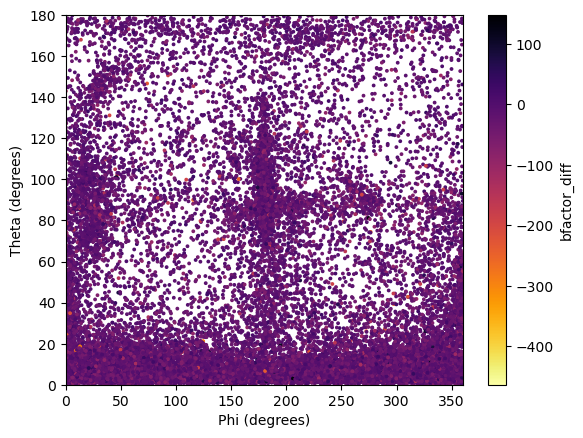

In [35]:
#Plot
import matplotlib.pyplot as plt

ax2 = piranose_df.plot.scatter(x='puck.phi_graus',
                   y='puck.theta_graus',
                   c='bfactor_diff',
                   colormap='inferno_r',
                   s=3)

ax2.set_xlim([0, 360])
ax2.set_ylim([0, 180])

ax2.set_xlabel('Phi (degrees)')
ax2.set_ylabel('Theta (degrees)')

plt.show()

In [ ]:
#Com filtros de resolução



In [13]:
# Célula pra debug SOMENTE
######
######
#Retorna a média do bfactor do açúcar

def sugar_bfactor_mean(file_path, sugar, first_atom):
    
    mmcif_dict = MMCIF2Dict(file_path)#_atom_site.B_iso_or_equiv
    
    # atom_group = mmcif_dict['_atom_site.group_PDB']
    # atom_site_id = mmcif_dict['_atom_site.id'] 
    # atom_comp_id = mmcif_dict['_atom_site.label_comp_id']
    # atom_label_id = mmcif_dict['_atom_site.label_atom_id']
    # bfactors = mmcif_dict['_atom_site.B_iso_or_equiv']
    # entity_id = mmcif_dict['_atom_site.label_entity_id']
    # entity_seq_num = mmcif_dict['_atom_site.label_seq_id']
    
    # junta os dataframes dos monossacarídeos
    atom_df_dict = {"group": mmcif_dict['_atom_site.group_PDB'], 
                    "atom_id": mmcif_dict['_atom_site.id'], 
                    "comp":  mmcif_dict['_atom_site.label_comp_id'], 
                    "atom_symbol": mmcif_dict["_atom_site.type_symbol"], 
                    "atom_label": mmcif_dict['_atom_site.label_atom_id'], 
                    "bfactors": mmcif_dict['_atom_site.B_iso_or_equiv'], 
                    "entity_id": mmcif_dict['_atom_site.label_entity_id'],
                    "entity_seq_num": mmcif_dict['_atom_site.label_seq_id'],
                    "auth_seq_id": mmcif_dict['_atom_site.auth_seq_id']}
    atom_df = pd.DataFrame(data = atom_df_dict)

    #Converte os valores de bfactor pra float
    atom_df['bfactors'] = atom_df["bfactors"].astype(float)
    atom_df['atom_id'] = atom_df["atom_id"].astype(int)

    #Separa os hetero atomos
    hetatm_df = atom_df.loc[atom_df['group'] == 'HETATM']

    #Remove as moléculas de água
    hetatm_df = hetatm_df.loc[hetatm_df['comp'] != 'HOH']

    #Separa so os carboidratos
    carbo_dict = pd.read_csv("/home/douglas/carboanalysis/carboanalysis/pdb/dicts/CCD_carbohydrate_list.tsv", sep = "\t", header = None, names = ['carbo_id', 'release_status'])
    carbo_list = carbo_dict["carbo_id"].values
    hetatm_df = hetatm_df.loc[hetatm_df['comp'].isin(carbo_list)]

    #reseta os index
    hetatm_df = hetatm_df.reset_index()

    #Filtra df com o nome e o número do primeiro átomo do açúcar
    filtered_df = hetatm_df[hetatm_df['atom_id'] >= first_atom]
    filtered_df = filtered_df[filtered_df['comp'] >= sugar]
    filtered_df = filtered_df.reset_index()

    #Itera os açúcares e escreve um arquivo no formato pdb pra cada um deles
    for index, row in filtered_df.iterrows():
        if(index == 0):
            iter_auth_seq_id = row["auth_seq_id"]
            iter_sugar = row["comp"]
            bfactor_acm = row["bfactors"]
            atom_cont = 1
        else:
            #Verifica se mudou de açúcar
            if(row["comp"] != iter_sugar or row["auth_seq_id"] != iter_auth_seq_id):
                bfactor_acm += row["bfactors"]
                atom_cont += 1
                sugar_mean = bfactor_acm/atom_cont if atom_cont > 0 else 0
                return sugar_mean
            
            #Verifica se é a última linha
            if(index == len(filtered_df.index) - 1):
                bfactor_acm += row["bfactors"]
                atom_cont += 1
                sugar_mean = bfactor_acm/atom_cont if atom_cont > 0 else 0
                return sugar_mean
            
            bfactor_acm += row["bfactors"]
            atom_cont += 1

sugar = "6zho_GLC_4663"

# Separar a string usando o delimitador '_'
part1, part2, part3 = sugar.split('_')

# Atribuir a variáveis
cif_filename = part1 + ".cif"
sugar = part2
first_atom = int(part3)

polymer_mean = polymer_bfactor_mean("/home/douglas/carboanalysis/data/unzipped/" + cif_filename)

print(polymer_mean)

# Calcula a média do bfactor do açúcar
sugar_mean = sugar_bfactor_mean("/home/douglas/carboanalysis/data/unzipped/" + cif_filename, sugar, first_atom)

print(sugar_mean)

18.740534193548385
9.633096363636364
